# Recommendation System for Retail
#### Introduction
A recommendation system is an essential tool for personalizing customer experiences, driving engagement, and improving sales for retail businesses. The system described in the code leverages customer-product interactions to predict the likelihood of future purchases and recommends products tailored to individual customers. This type of system is based on a filtering approach using deep learning models, which has the ability to capture complex relationships between users and products.

---

#### Benefits of the Recommendation System

- **Personalized Shopping Experience**: By predicting the products that customers are likely to purchase, the system provides tailored recommendations. This enhances the user experience, as customers are shown items they are more likely to be interested in, increasing their satisfaction.

- **Increased Sales and Revenue**: Personalized recommendations encourage cross-selling and upselling by suggesting complementary or higher-value products. This often leads to customers purchasing more items or upgrading their current selections, thus increasing revenue.

- **Customer Retention**: By regularly providing personalized recommendations, retailers can engage customers and make them more likely to return. This continuous engagement can improve customer loyalty and retention rates.

- **Efficient Inventory Management**: By understanding which products are likely to be in demand, retailers can better manage inventory, ensuring that popular items are always available while minimizing overstock of less popular products.

### How Retail Companies Can Leverage This System

- **E-commerce Platforms**: Online retailers can integrate this recommendation system into their e-commerce websites or apps to personalize the shopping experience. For instance, when a customer logs in, the system can recommend products based on their previous purchases, similar customers' behaviors, or trending products. This enhances customer satisfaction and boosts sales.

- **Email and Push Notifications**: Retailers can use the system to send personalized email newsletters or push notifications with product recommendations based on user preferences. By analyzing past purchases, customer profiles, and browsing behavior, the system can ensure that communications are more relevant, leading to higher open rates and conversions.

- **Customer Segmentation**: The system helps segment customers into different groups based on their purchasing behavior. These segments can be targeted with specific offers, promotions, or product bundles, ensuring more efficient and relevant marketing strategies.

- **Improved Customer Service**: By predicting the likelihood of future purchases, customer service teams can proactively suggest relevant products when assisting customers. This helps in building a more personalized and attentive experience, which can lead to greater customer satisfaction and retention.

---

### Step 1: Loading and Preprocessing the Data

This initial step focuses on importing necessary libraries and loading the dataset for analysis. We use `pandas` to load the data from a CSV file and preview the first few rows with the `head()` function. This helps us ensure that the data is correctly loaded and ready for processing.

In [11]:
import pandas as pd
import numpy as np
# Load the dataset into a pandas DataFrame

data = pd.read_csv('../data/processed/retail_sales_dataset.csv')
data.head()

,Transaction ID,Date,Product Category,Quantity,Price per Unit,Total Amount,Customer ID,Gender,Age,City,Province,Country,Season,is_discount,Customer Type,Total Spend,Product ID
0,1,2023-01-01,Beauty,3,500,1500,CUST045,Female,55,Montreal,Quebec,Canada,Winter,True,New,10525,5
1,2,2023-01-01,Clothing,3,300,900,CUST041,Male,34,Charlottetown,Prince Edward Island,Canada,Winter,True,New,7650,9
2,3,2023-01-01,Clothing,4,300,1200,CUST022,Male,18,Gatineau,Quebec,Canada,Winter,True,New,11785,9
3,4,2023-01-02,Electronics,3,30,90,CUST007,Male,46,Saint John,New Brunswick,Canada,Winter,True,New,4910,12
4,5,2023-01-02,Beauty,1,25,25,CUST044,Female,22,Gatineau,Quebec,Canada,Winter,True,New,8150,1


### Step 2: Data Transformation

We transform the data into a format suitable for building a recommendation system. We start by creating a user-product interaction matrix, where each row represents a customer-product pair, and the `purchases` column indicates whether the customer bought the product.

In [12]:
# Create a user-product interaction matrix
interaction_data = data.groupby(['Customer ID', 'Product ID']).size().reset_index(name='purchases')
interaction_data['Customer ID'] = interaction_data['Customer ID'].str.extract('(\d+)').astype(int)

interaction_data.head()

,Customer ID,Product ID,purchases
0,1,2,1
1,1,4,3
2,1,6,3
3,1,7,2
4,1,8,4


### Step 3: Train-Test Split
We now split the data into training and testing sets. The training set will be used to train the model, while the testing set will allow us to evaluate its performance. After splitting, we extract the customer, product, and purchases columns and convert them into numpy arrays for compatibility with machine learning models.

In [13]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, test_data = train_test_split(interaction_data, test_size=0.2, random_state=42)

# Convert to numpy arrays
customer_train = train_data['Customer ID'].values
product_train = train_data['Product ID'].values
purchases_train = train_data['purchases'].values

customer_test = test_data['Customer ID'].values
product_test = test_data['Product ID'].values
purchases_test = test_data['purchases'].values

### Step 4: Building the Recommendation Model

 We define a deep learning model using TensorFlow/Keras. The model is based on an embedding technique, where customer and product IDs are transformed into vectors (embeddings) in a latent space.

In [14]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class RegressionModel(Model):
    def __init__(self, embedding_size, max_customer_id, max_product_id, hidden_units=128, dropout_rate=0.2):
        super().__init__()

        # Embedding layers for users and items (products)
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_customer_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_product_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # Flatten the embeddings to vectors
        self.flatten = Flatten()
        
        # Dense layers for further processing
        self.dense1 = Dense(hidden_units, activation='relu', kernel_regularizer=l2(0.01), name="dense1")
        self.dropout1 = Dropout(dropout_rate, name="dropout1")
        self.dense2 = Dense(hidden_units // 2, activation='relu', kernel_regularizer=l2(0.01), name="dense2")
        self.dropout2 = Dropout(dropout_rate, name="dropout2")

        # Dot layer for interaction between user and item vectors
        self.dot = Dot(axes=1)

        # Output layer for predicting the purchase likelihood
        self.output_layer = Dense(1, activation='linear', name="output_layer")

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        # Get embeddings for users and items
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        # Apply dense layers after flattening the embeddings
        x = self.dot([user_vecs, item_vecs])
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)

        # Final output layer
        y = self.output_layer(x)
        return y

# Number of unique customers and products
max_customer_id = interaction_data['Customer ID'].max()
max_product_id = interaction_data['Product ID'].max()

# Create and compile the model
model = RegressionModel(embedding_size=64, 
                        max_customer_id=max_customer_id, 
                        max_product_id=max_product_id,
                        hidden_units=128,    # You can change this based on your requirements
                        dropout_rate=0.2)    # You can change the dropout rate if needed

# Compile the model with Adam optimizer and MAE loss for regression predictions
model.compile(optimizer=Adam(), loss='mae') 
model.summary()

C:\Users\charles\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "regression_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_1 (Dot)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Step 5: Training the Model

We train the recommendation model using the training data. The model is trained using a batch size of 64 and 10 epochs. We also monitor both training and validation loss to ensure the model is not overfitting or underfitting.

In [15]:
# Train the model
history = model.fit([customer_train, product_train], purchases_train,
                                      batch_size=64, epochs=10, validation_data=([customer_test, product_test], purchases_test))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2.7323 - val_loss: 2.3229
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5706 - val_loss: 2.1521
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3625 - val_loss: 1.9656
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2022 - val_loss: 1.7466
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9841 - val_loss: 1.4769
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7014 - val_loss: 1.1357
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3638 - val_loss: 1.0794
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2662 - val_loss: 1.0710
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2146 - val_loss: 1.0508
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1732 - val_loss: 1.0237


### Step 6: Evaluating the Model
After training, we can evaluate the model using the `model.evaluate(`) function on the test data. This will compute the loss and return the test performance. Since we are using Mean Absolute Error (MAE) as the loss, it will return that value.

In [16]:
test_loss = model.evaluate([customer_test, product_test], purchases_test, batch_size=64)
print(f'Test Loss (MAE): {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0254
Test Loss (MAE): 1.0237114429473877


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on test set
predictions = model.predict([customer_test, product_test])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(purchases_test, predictions))
print(f'RMSE: {rmse}')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022473BEB3A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE: 0.8845108015286303


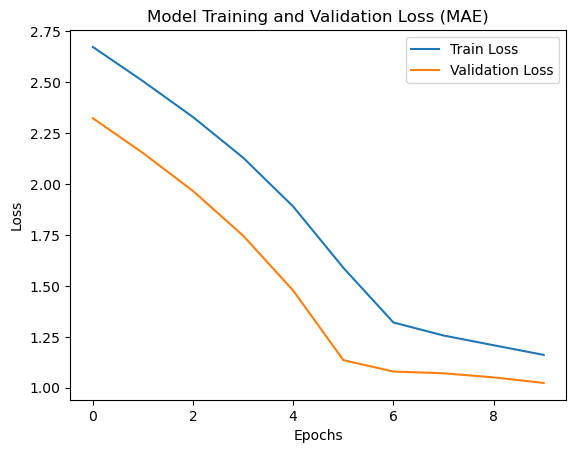

In [18]:
# Plot the training and validation loss to monitor progress
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add title and legend
plt.legend(loc='best')
plt.title('Model Training and Validation Loss (MAE)')

# Show the plot
plt.show()

### Step 7: Making Predictions and Recommendations

Using the trained model, we make predictions for product recommendations for a given user. 
The function `recommend_products()` predicts the likelihood that a user will purchase each product and returns the top N recommendations.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image

product_data = pd.read_csv('../data/processed/products.csv')
# Create a dictionary for quick lookup
product_info = product_data.set_index('Product ID').to_dict(orient='index')


def cosine(a, b):
    # Reshape to the shape our function expects (1, -1)
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]


#Function for recommending 5 products for a given Customer Id
def recommend_products(user_id, top_n=5):

    product_ids = range(max_product_id + 1)
    
    # Predict purchase likelihood for all products for the given user
    user_array = np.full_like(product_ids, user_id)
    product_embeddings = model.predict([user_array, np.array(product_ids)])

    # Normalize the embeddings for cosine similarity
    product_embeddings = np.array(product_embeddings).flatten()
    
    # Get the top N recommendations based on predicted likelihood
    top_items = product_embeddings.argsort()[-top_n:][::-1]
    
    # Return product IDs and their predicted purchase likelihood
    recommended_products = [(item, product_embeddings[item]) for item in top_items]

    return recommended_products


# Function to display a grid of product images
def display_product_images_grid(product_ids,user_id):
    plt.figure(figsize=(15, 3))  # Set the size of the grid (15 inches wide, 3 inches tall)
    plt.suptitle(f"Top 5 Recommendations for User ID: {user_id}", fontsize=12, fontweight='bold')

    for idx, product_id in enumerate(product_ids):
        # Get product info (name, category, price) from the product_info dictionary
        info = product_info.get(product_id, None)
        if info is not None:
            product_name = info['Product Name']
            image_path = f'../data/processed/images/{product_id}.jpg'  # Assuming images are named as 1.jpg, 2.jpg, etc.
            
            try:
                # Open the image using Pillow
                img = Image.open(image_path)
                
                # Resize the image to 10% of its original size
                img_resized = img.resize((int(img.width * 0.1), int(img.height * 0.1)))
                
                # Convert the resized image back to an array for matplotlib
                img_resized = np.array(img_resized)
                
                # Add the image to the grid (1 row, 5 columns)
                plt.subplot(1, 5, idx + 1)  # Row 1, column 5, position idx+1
                plt.imshow(img_resized)
                plt.axis('off')  # Hide the axis
                plt.title(product_name, fontsize=8)
            except FileNotFoundError:
                print(f"Image not found for product ID {product_id}")
        else:
            print(f"Product info not found for product ID {product_id}")
    
    # Show the grid with all images
    plt.tight_layout()
    plt.show()




def generate_recommendations(user_id):
    print(f'\n-------------------------------------------------------------------------')
    print(f'These are the recommendations for Customer ID :{user_id}')
    recommendations = recommend_products(user_id, top_n=5)
    for product_id, predicted_purchase in recommendations:
        print(f'Product ID: {product_id}')
    print(f'-------------------------------------------------------------------------\n')
    
    recommended_product_ids = [product_id for product_id, predicted_purchase in recommendations]
    display_product_images_grid(recommended_product_ids,user_id)
    product_ids = [rec[0] for rec in recommendations]
    predicted_purchases = [rec[1] for rec in recommendations]
    plt.figure(figsize=(5, 3))
    plt.bar(product_ids, predicted_purchases)
    plt.xlabel('Product ID')
    plt.ylabel('Predicted Purchase Likelihood')
    plt.title(f'Top 5 Product Recommendations for User {user_id}')
    plt.show()

    return

### Step 8: Testing the recommendations

We can test the recommendations for different users, by passing the Ids to the `generate_recommendation` function

Recommendations for Customer ID: 25

-------------------------------------------------------------------------
These are the recommendations for Customer ID :25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Product ID: 9
Product ID: 13
Product ID: 8
Product ID: 1
Product ID: 11
-------------------------------------------------------------------------



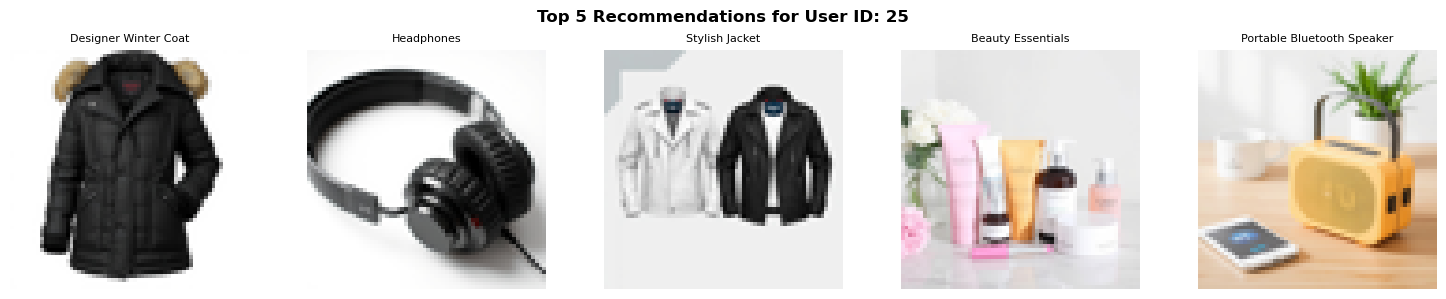

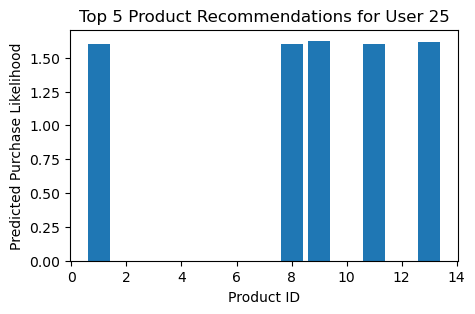

Recommendations for Customer ID: 44

-------------------------------------------------------------------------
These are the recommendations for Customer ID :44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Product ID: 14
Product ID: 8
Product ID: 9
Product ID: 1
Product ID: 15
-------------------------------------------------------------------------



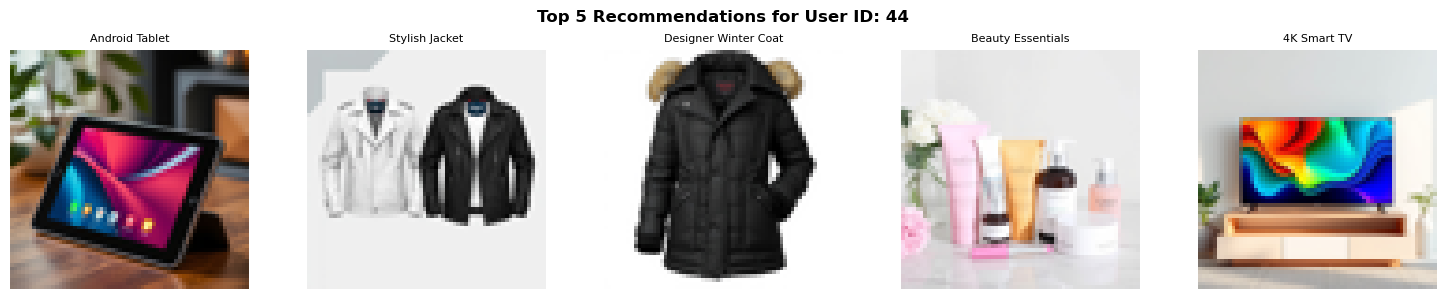

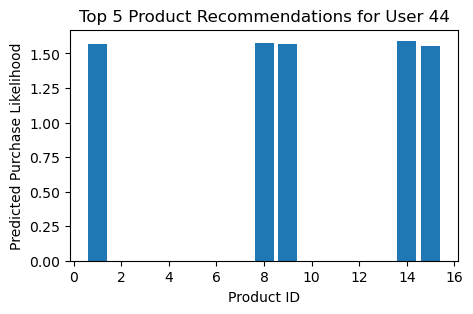

Recommendations for Customer ID: 48

-------------------------------------------------------------------------
These are the recommendations for Customer ID :48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Product ID: 4
Product ID: 5
Product ID: 13
Product ID: 12
Product ID: 7
-------------------------------------------------------------------------



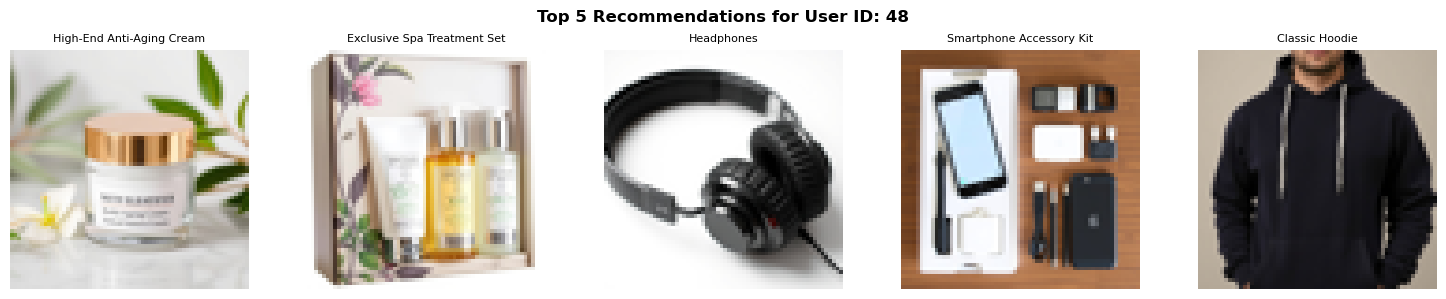

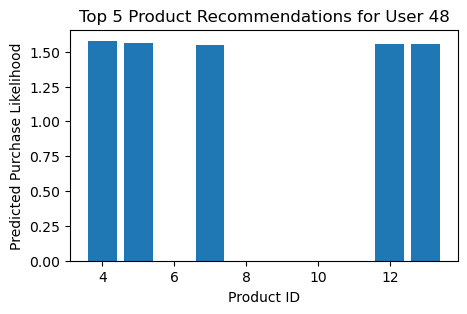

In [20]:
import random
customer_ids = interaction_data['Customer ID'].unique()

random_ids = random.sample(list(customer_ids), 3)
for user_id in random_ids:
    print(f"Recommendations for Customer ID: {user_id}")
    generate_recommendations(user_id)

---

## Key Features of the Code Implementation

**Data Preprocessing and Transformation**:

- The dataset is loaded and transformed into a user-product interaction matrix, where each entry represents a customer's purchase of a product. This matrix is crucial for training the model as it captures customer-product interactions.

**Deep Learning Model (Embeddings)**:

- The recommendation model uses embeddings to map both customers and products into a latent space. These embeddings allow the model to learn hidden relationships between users and items, which are key to predicting future purchases.

- The model architecture consists of an embedding layer for both customers and products, a dense neural network layer for further processing, and a dot product to compute the interaction between user and product embeddings.

**Training and Evaluation**:

- The model is trained using Mean Absolute Error (MAE) as the loss function, and the training is monitored to avoid overfitting. Additionally, the performance is evaluated using metrics like RMSE (Root Mean Squared Error), which provides insights into how well the model generalizes to unseen data.

**Recommendations Generation**:

- After training, the model can predict the likelihood of purchases for any customer-product pair, generating personalized product recommendations for a given customer.

- The system returns the top N product recommendations for each customer, which can be further enriched with product images and details for a more compelling user interface.

**Cosine Similarity for Product Similarity**:

- The system can compute cosine similarity between products to suggest similar items, enhancing the variety of recommendations. This is beneficial for cross-selling and offering alternative products to customers.

**Visualization**:

- The code visualizes the recommendations and purchase likelihood through bar charts and product images. This can be integrated into a retail company’s interface to visually highlight product suggestions, improving customer engagement

# Conclusion

This recommendation system provides numerous benefits to retail companies by improving customer experience, increasing sales, and driving better decision-making. By utilizing deep learning and customer-product interaction data, retailers can create highly personalized shopping experiences that are predictive and dynamic. This system empowers e-commerce platforms and physical retail stores alike to enhance customer engagement, optimize inventory, and ultimately achieve greater business success.